### USE EQNS FROM THE CHINESE PAPER ONLY

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import multiprocessing as mul
from scipy import stats
import pickle
from scipy.integrate import quad
from corner import corner
import pandas as pd
from scipy.stats import gaussian_kde
import emcee

In [2]:
ncpu = mul.cpu_count()
grbparam = pd.read_csv(os.getcwd() + '/../data/GRBPARAM.csv', index_col=0)

param_ranges_NULL = [(1e-20, 5000), (-3, 10), (-10, 3), (0, 3), (0, 4)]
param_range_lin = [(1e-20, 1e20), (1e-20, 5000), (-3, 10), (-10, 3), (0, 3), (0, 4)]
param_range_quad = [(1e-20, 1e15), (1e-20, 5000), (-3, 10), (-10, 3), (0, 3), (0, 4)]


GRBs = ['GRB210619B', 'GRB210610B', 'GRB210204A', 'GRB201216C', 'GRB200829A', 'GRB200613A', 'GRB190114C', 'GRB180720B', 'GRB180703A', 'GRB171010A', 'GRB160625B', 'GRB160509A', 'GRB150821A', 'GRB150514A', 'GRB150403A', 'GRB150314A', 'GRB141028A', 'GRB140508A', 'GRB140206A', 'GRB131231A', 'GRB131108A', 'GRB130925A', 'GRB130518A', 'GRB130427A', 'GRB120119A', 'GRB100728A', 'GRB091003A', 'GRB090926A', 'GRB090618', 'GRB090328', 'GRB081221', 'GRB080916C']


grb = GRBs[0]
grbname = grb + '.txt'
grbname_wtht_ext = grbname.replace('.txt','')


arr = np.loadtxt(os.getcwd() + '/asciidataof_fig1/32lag/'+grbname)
data = [arr[:,0], arr[:,1], arr[:,2]]
x = arr[:,0]
y = arr[:,1]
yerr = arr[:,2]

#Properties of GRB
E0 = grbparam[grbname.replace('.txt','')].E0
E0rest = E0
Erest = arr[:,0]    #in keV
z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
H0=67.36 #Hubble constant km -1 Mpc s -1
omega_m = 0.315
omega_l = 1 - omega_m

In [3]:
grb

'GRB210619B'

In [4]:
#MODELS

#NULL model
def nullhp(E, logEb, alpha1, alpha2, mu, zeta):
    
    eob = (E - E0) / (logEb)
    
    return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))


def int_z(z_prime, n):
    integ_fn = lambda z: (1+z)**n / np.sqrt(omega_m * (1+z)**3 + omega_l)
    return quad( integ_fn, a=0, b=z_prime)[0]

int_z1 = np.asarray(int_z(z_com, 1))
int_z2 = np.asarray(int_z(z_com, 2))

#LINEAR model
def linearhp(E, logEqg, logEb, alpha1, alpha2, mu, zeta):
    
    e0qg = (E - E0) / (10 ** logEqg)
    
    return - (e0qg * int_z1)/H0 + nullhp(E, logEb, alpha1, alpha2, mu, zeta)

#QUADRATIC model
def quadhp(E, logEqg, logEb, alpha1, alpha2, mu, zeta):
    e0qg = (E**2 - E0 **2) / ((10 ** logEqg)**2)
    
    return -1.5 * (e0qg * int_z2)/H0 + nullhp(E, logEb, alpha1, alpha2, mu, zeta)

In [5]:
#LOG-LIKELIHOODS
def loglike_null(theta):
    logEb, alpha1, alpha2, mu, zeta = theta
    
    if alpha1 >= alpha2:
        model = nullhp(x,  logEb, alpha1, alpha2, mu, zeta)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
    
    return -np.inf

def loglike_linear(theta):
    logEqg, logEb, alpha1, alpha2, mu, zeta = theta
    
    if alpha1 >= alpha2:
        model = linearhp(x, logEqg, logEb, alpha1, alpha2, mu, zeta)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
    
    return -np.inf

def loglike_quad(theta):
    logEqg, logEb, alpha1, alpha2, mu, zeta = theta
    
    if alpha1 >= alpha2:
        model = quadhp(x, logEqg, logEb, alpha1, alpha2, mu, zeta)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
    
    return -np.inf    

In [6]:
#PRIORS
logEbmax = 3000 #keV
logEbmin = 0
alpha1min = -3
alpha1max = 10
alpha2min = -10
alpha2max = 3
mumin = 0
mumax = 3
zetamin = 0
zetamax = 4
eqglinmin = 1e-20
eqglinmax = 1e20
eqquadmin = 1e-20
eqquadmax = 1e15
logeq1min = -20
logeq1max = 20
logeq2min = -20
logeq2max = 15

In [7]:
#PRIORS

def logprior_null(theta):
    logEb, alpha1, alpha2, mu, zeta = theta
    
    if logEbmin < logEb < logEbmax and -alpha1min < alpha1 < alpha1max and alpha2min < alpha2 < alpha2max and mumin < mu < mumax and zetamin < zeta < zetamax:
        return 0
    
    return -np.inf

def logprior_linear(theta):
    logEqg, logEb, alpha1, alpha2, mu, zeta = theta
    
    if logEqg < logeq1max and logEbmin < logEb < logEbmax and -alpha1min < alpha1 < alpha1max and alpha2min < alpha2 < alpha2max and mumin < mu < mumax and zetamin < zeta < zetamax:
        return 0
    
    return -np.inf

def logprior_quad(theta):
    logEqg, logEb, alpha1, alpha2, mu, zeta = theta
    
    if logEqg < logeq2max and logEbmin < logEb < logEbmax and -alpha1min < alpha1 < alpha1max and alpha2min < alpha2 < alpha2max and mumin < mu < mumax and zetamin < zeta < zetamax:
        return 0
    
    return -np.inf

In [8]:
#POSTERIORS

def logpost_null(theta):
    logp = logprior_null(theta)
    
    if not np.isfinite(logp):
        return -np.inf
    
    return logp + loglike_null(theta)

def logpost_linear(theta):
    logp = logprior_linear(theta)
    
    if not np.isfinite(logp):
        return -np.inf
    
    return logp + loglike_linear(theta)

def logpost_quad(theta):
    logp = logprior_quad(theta)
    
    if not np.isfinite(logp):
        return -np.inf
    
    return logp + loglike_quad(theta)

In [9]:
#SAMPLING
nwalkers = 200
ndim_null = 5
nsteps = 5000
nburnin = 500
init_null = np.array([np.random.uniform(logEbmin, logEbmax, nwalkers), np.random.uniform(alpha1min, alpha1max, nwalkers), np.random.uniform(alpha2min, alpha2max, nwalkers), np.random.uniform(mumin, mumax, nwalkers), np.random.uniform(zetamin, zetamax, nwalkers)]).T

sampler0 = emcee.EnsembleSampler(nwalkers, ndim_null, logpost_null, pool=mul.Pool(8), threads=8)

sampler0.run_mcmc(init_null, nsteps, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]/home/darkwake/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 6/5000 [00:00<04:44, 17.53it/s]

  1%|          | 27/5000 [00:01<04:59, 16.63it/s]/tmp/ipykernel_13218/2008632300.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  1%|          | 44/5000 [00:02<05:18, 15.56it/s]/tmp/ipykernel_13218/2008632300.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  3%|▎         | 154/5000 [00:09<05:04, 15.93it/s]/tmp/ipykernel_13218/2008632300.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  4%|▍         | 197/5000 [00:11<04:40, 17.14it/s]/tmp/ipykernel_13218/2008632300.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  4%|▍         | 203/5000 [00:12<04:38, 17.20it/s]/tmp/ipykernel_13218/2008632300.py:8: RuntimeWarning: ov

State([[ 4.38242473e+00  8.54076260e+00  1.46865588e-01  3.00232149e-02
   3.87487619e-01]
 [ 1.27021991e+01  4.59671295e+00  1.12238077e-01  1.75895952e-01
   3.81631994e-01]
 [ 1.59967520e+01  3.10248490e+00  1.42827178e-01  9.51001385e-02
   4.83940124e-01]
 [ 1.55455420e+01  3.44648781e+00  1.15964962e-01  2.22775819e-01
   3.97040219e-01]
 [ 1.14955807e+01  4.11355434e+00  1.35299993e-01  1.66228413e-01
   3.62548740e-01]
 [ 1.69625448e+01  3.34819602e+00  1.05856056e-01  4.07975600e-01
   2.74903523e-01]
 [ 6.20737612e+00  7.24713021e+00  1.18670871e-01  2.48916512e-01
   1.66110723e-01]
 [ 1.25387887e+01  3.96371382e+00  1.25945635e-01  4.85664965e-01
   1.68355741e-01]
 [ 1.24376404e+01  3.44001248e+00  1.55165413e-01  1.65079116e-01
   3.64127210e-01]
 [ 8.38730635e+00  5.87056844e+00  1.25879401e-01  3.69125071e-02
   4.96021809e-01]
 [ 1.13526774e+01  3.98425403e+00  1.32388604e-01  1.64423411e-01
   3.69570643e-01]
 [ 7.94752360e+00  5.01872824e+00  1.50057166e-01  3.832509

In [10]:
#LINEAR
init_lin = np.array([np.random.uniform(logeq1min, logeq1max, nwalkers), np.random.uniform(logEbmin, logEbmax, nwalkers), np.random.uniform(alpha1min, alpha1max, nwalkers), np.random.uniform(alpha2min, alpha2max, nwalkers), np.random.uniform(mumin, mumax, nwalkers), np.random.uniform(zetamin, zetamax, nwalkers)]).T
ndim_liv = 6
sampler1 = emcee.EnsembleSampler(nwalkers, ndim_liv, logpost_linear, pool=mul.Pool(8), threads=8)
sampler1.run_mcmc(init_lin, nsteps, progress=True)

  1%|▏         | 69/5000 [00:04<05:39, 14.51it/s]/tmp/ipykernel_13218/2008632300.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  3%|▎         | 160/5000 [00:09<05:03, 15.93it/s]/tmp/ipykernel_13218/2008632300.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  4%|▍         | 200/5000 [00:11<04:13, 18.93it/s]/tmp/ipykernel_13218/2008632300.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  4%|▍         | 207/5000 [00:12<04:27, 17.94it/s]/tmp/ipykernel_13218/2008632300.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  4%|▍         | 214/5000 [00:12<04:29, 17.75it/s]/tmp/ipykernel_13218/2008632300.py:8: RuntimeWarning: o

State([[ 3.27896631  5.1859509   7.45696102  0.15907915  0.13019855  0.2364411 ]
 [15.85828008 13.9510738   3.11187245  0.15223652  0.85839213  0.09322235]
 [11.34095811 16.19847306  3.14811603  0.13334762  0.42728661  0.25219518]
 ...
 [ 2.58765774  7.61643895  5.25460507  0.216761    0.1074708   0.28370163]
 [19.5109342  15.78969493  3.37550333  0.12073751  0.04526546  0.5847966 ]
 [ 2.88112496  9.64660631  4.09837381  0.19450125  0.09870092  0.34137099]], log_prob=[   22.33511443    19.45475773    20.35987424    19.60904263
    25.39791671    20.41707379    19.23887857    17.55538378
    18.968025    -923.01190244    18.02817397    17.15747979
    19.64204117    20.3562218  -1975.21696185    21.61640149
    26.2937957     20.37494669    25.85867541    25.10527224
    24.18061796    23.36480338    19.24428491    21.94946581
    17.41454081    19.58710049    19.54485793    25.9182855
    24.98101749    23.68516111    24.76525544    17.59713279
    25.40354066    18.81228512    21.8689

In [11]:
#QUADRATIC
init_quad = np.array([np.random.uniform(logeq2min, logeq2max, nwalkers), np.random.uniform(logEbmin, logEbmax, nwalkers), np.random.uniform(alpha1min, alpha1max, nwalkers), np.random.uniform(alpha2min, alpha2max, nwalkers), np.random.uniform(mumin, mumax, nwalkers), np.random.uniform(zetamin, zetamax, nwalkers)]).T

sampler2 = emcee.EnsembleSampler(nwalkers, ndim_liv, logpost_quad, pool=mul.Pool(8), threads=8)
sampler2.run_mcmc(init_quad, nsteps, progress=True)

  4%|▍         | 196/5000 [00:05<02:10, 36.74it/s]/tmp/ipykernel_13218/2008632300.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  4%|▍         | 216/5000 [00:06<02:08, 37.28it/s]/tmp/ipykernel_13218/2008632300.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  5%|▍         | 228/5000 [00:06<02:09, 36.92it/s]/tmp/ipykernel_13218/2008632300.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  5%|▍         | 232/5000 [00:06<02:10, 36.50it/s]/tmp/ipykernel_13218/2008632300.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  5%|▍         | 244/5000 [00:06<02:07, 37.24it/s]/tmp/ipykernel_13218/2008632300.py:8: RuntimeWarning: 

State([[ 9.57522189e+00  3.61589185e+02  3.00121510e+00 -1.25759860e+00
   1.15994959e+00  5.22890834e-01]
 [ 3.69025950e+00  4.69113286e+00  7.16014884e+00  1.93416561e-01
   6.27472128e-02  2.74356912e-01]
 [ 1.32723380e+01  1.92181824e+01  3.16900124e+00  1.17443923e-01
   7.26435743e-02  5.91365151e-01]
 ...
 [ 3.94750096e+00  1.03722693e+01  3.83673687e+00  1.63574688e-01
   4.92108997e-01  1.41644681e-01]
 [ 3.67562749e+00  4.11462053e+00  8.99914376e+00  1.71234411e-01
   3.07515177e-02  3.44482809e-01]
 [ 3.62029017e+00  1.23672532e+01  3.24639308e+00  1.94549470e-01
   3.23140735e-01  2.29824149e-01]], log_prob=[-1066.1615437     29.67135593    16.39444509    18.85734822
    30.36332245    27.37716094    25.96680099    20.48269606
    29.48425598    29.50600853    28.33844068    19.43300746
    19.53071423    27.34361129    28.62794237    29.63255231
    27.19187741    20.29949137    29.34520855    28.6012825
    29.7459961     29.3418674     29.68032701    28.23738938
    27.

In [12]:
#DISCARD BURN-IN
samples0 = sampler0.get_chain(discard=nburnin, flat=True)
truths0 = [np.median(samples0[:,i]) for i in range(ndim_null)]
samples1 = sampler1.get_chain(discard=nburnin, flat=True)
truths1 = [np.median(samples1[:,i]) for i in range(ndim_liv)]
samples2 = sampler2.get_chain(discard=nburnin, flat=True)
truths2 = [np.median(samples2[:,i]) for i in range(ndim_liv)]

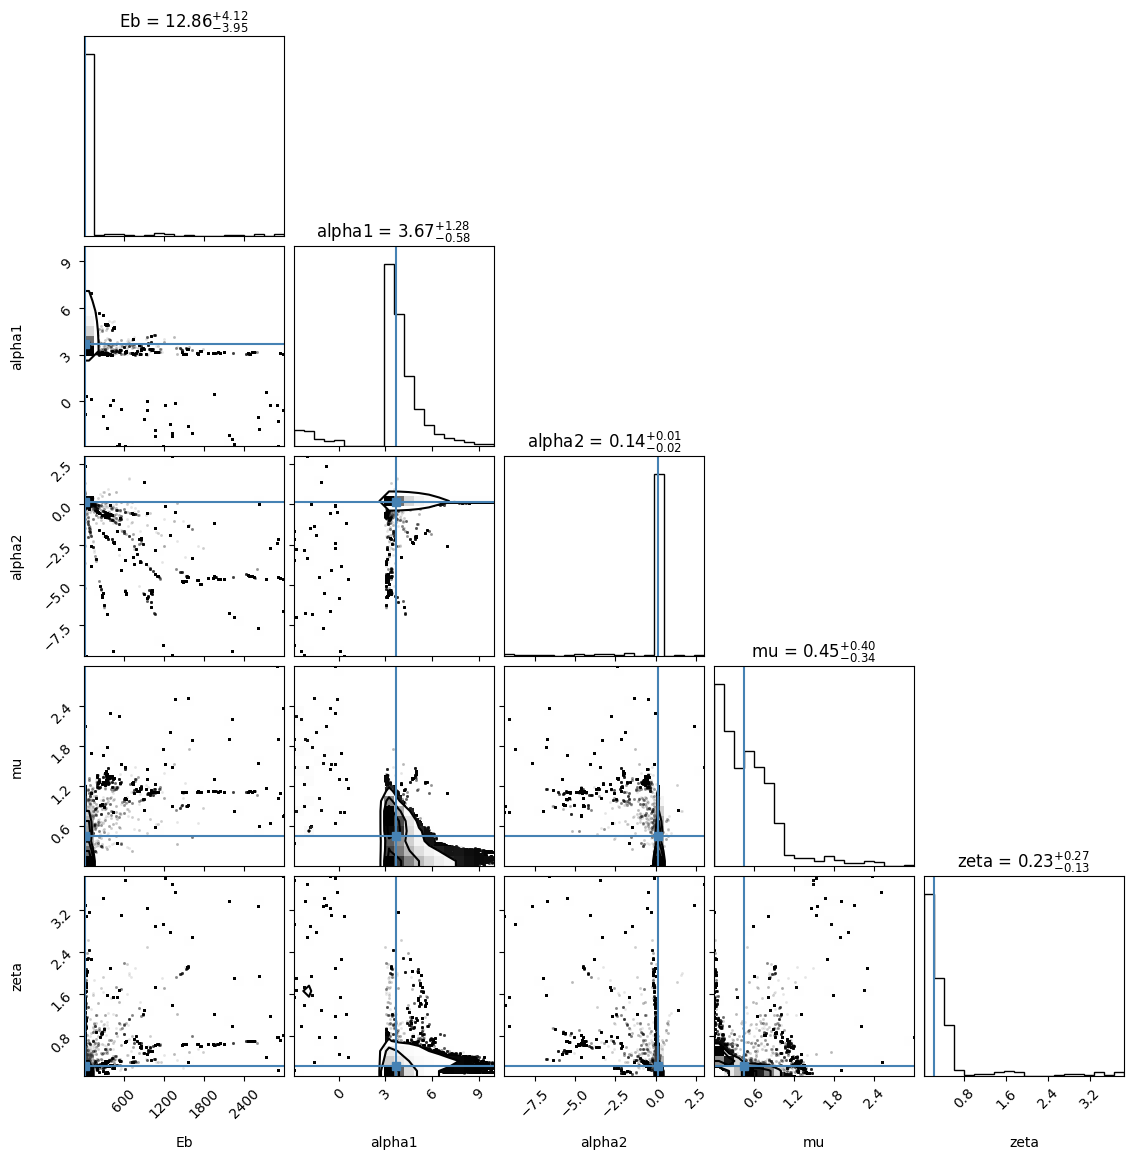

In [13]:
fig = corner(samples0, labels=['Eb', 'alpha1', 'alpha2', 'mu', 'zeta'], truths=truths0, hist_kwargs={'density' : True}, show_titles=True, title_kwargs={"fontsize": 12})

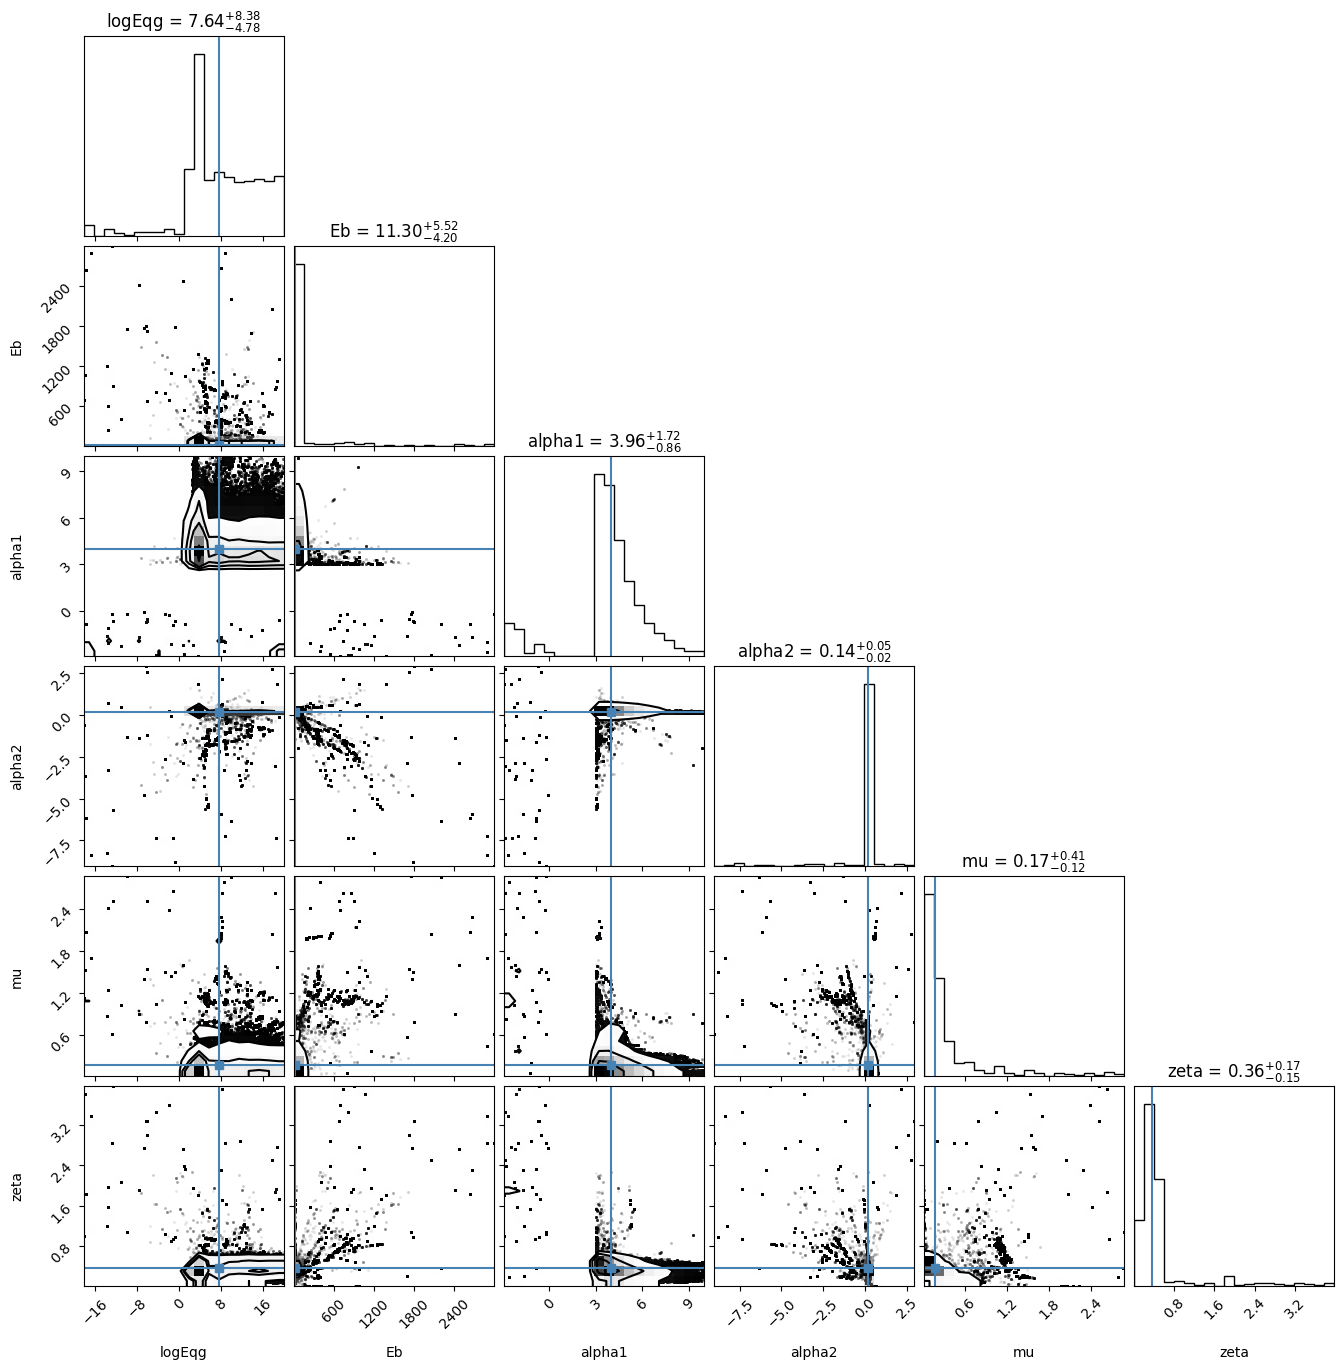

In [14]:
fig1 = corner(samples1, labels=['logEqg', 'Eb', 'alpha1', 'alpha2', 'mu', 'zeta'], truths=truths1, hist_kwargs={'density' : True}, show_titles=True, title_kwargs={"fontsize": 12})

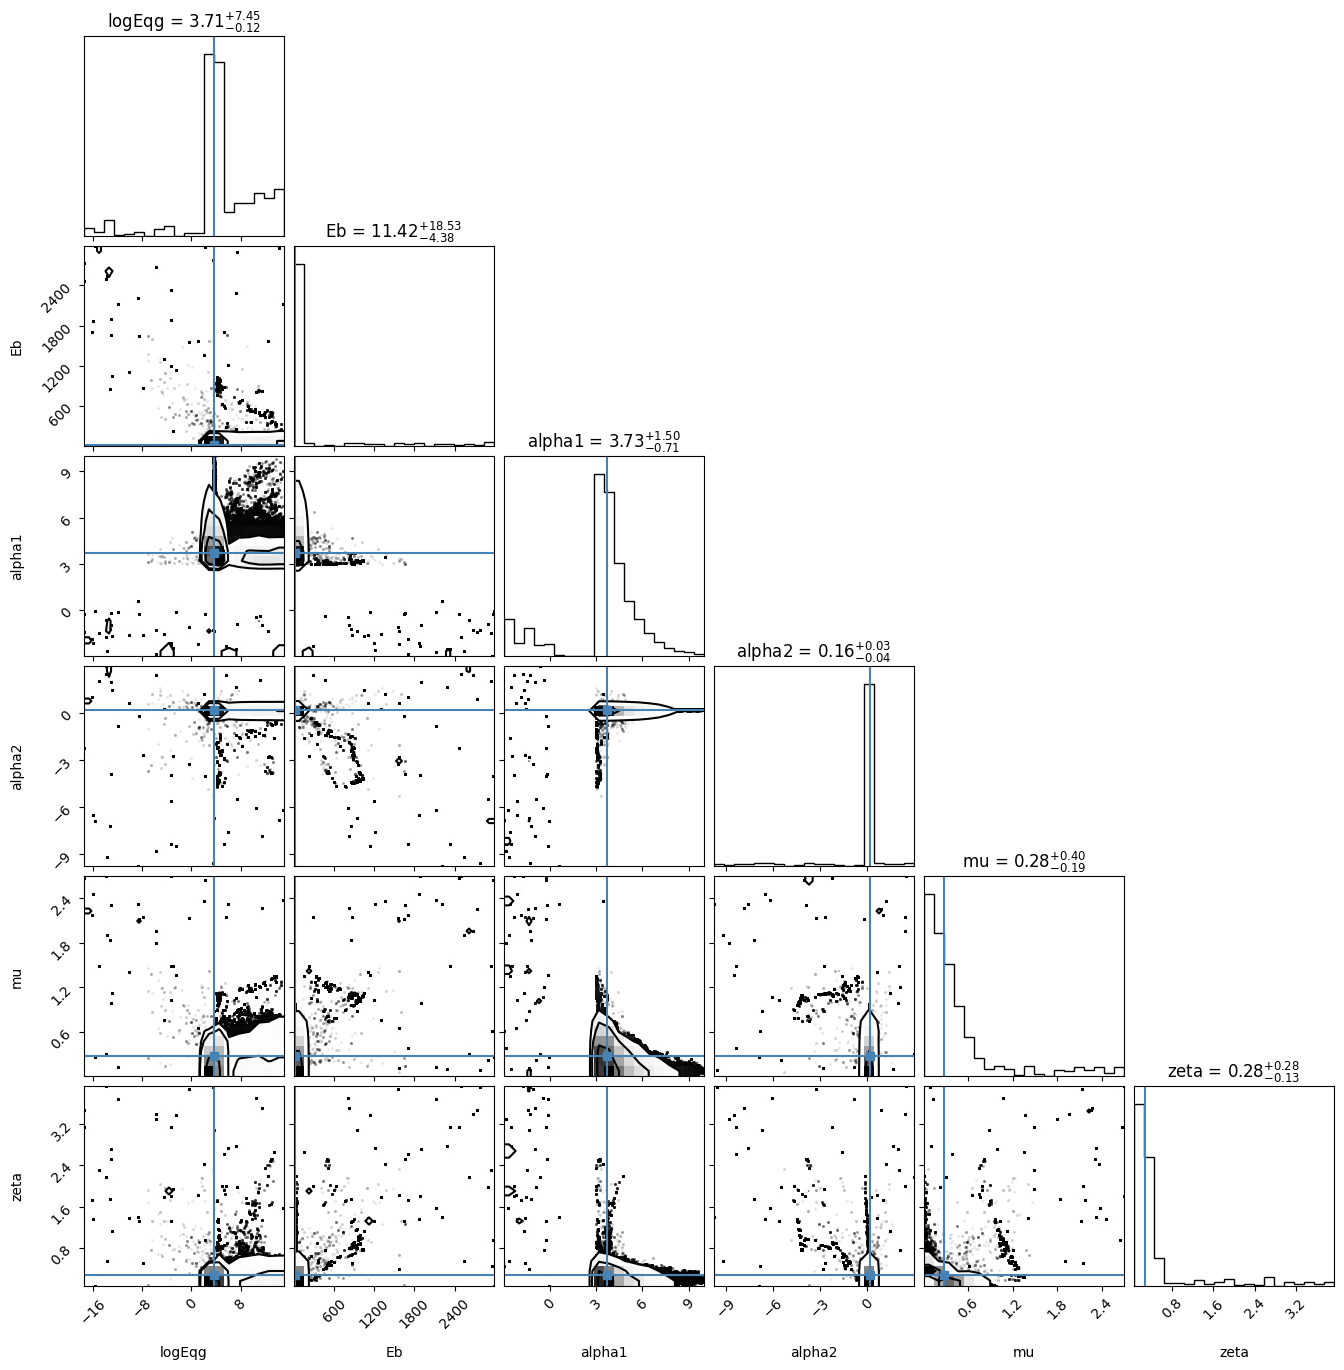

In [15]:
fig2 = corner(samples2, labels=['logEqg', 'Eb', 'alpha1', 'alpha2', 'mu', 'zeta'], truths=truths2, hist_kwargs={'density' : True}, show_titles=True, title_kwargs={"fontsize": 12})

In [16]:
sampler0.

array([[-1.19006004e+13, -7.21542031e+04, -1.41572069e+08, ...,
                   -inf, -5.11060268e+03, -4.88206172e+03],
       [-3.38797651e+12, -7.21542031e+04, -1.41572069e+08, ...,
                   -inf, -5.11060268e+03, -4.88206172e+03],
       [-3.38797651e+12, -7.21542031e+04, -1.41572069e+08, ...,
                   -inf, -2.49030403e+03, -4.88206172e+03],
       ...,
       [ 1.92245327e+01,  1.49410372e+01,  2.01422417e+01, ...,
         1.93361849e+01,  1.91111274e+01,  1.96914197e+01],
       [ 1.92245327e+01,  1.49410372e+01,  2.01422417e+01, ...,
         1.93361849e+01,  1.91111274e+01,  1.96914197e+01],
       [ 1.92245327e+01,  1.49410372e+01,  2.01422417e+01, ...,
         1.93361849e+01,  1.91111274e+01,  1.96914197e+01]])